In [9]:
import pandas as pd
import numpy as np
import pymysql
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import warnings
import statistics
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)


from IPython.display import HTML


In [2]:
import IPython.core.display as di

di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)


In [10]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Connects to Mercury
# Selects booking requests data, where the delivery date is between 10th and 15th of February 2020
# Booking requests when order changes - look what fields are important

connection = pymysql.connect(host = 'localhost',
                            user = 'devs_readonly',
                            password = 'cvspOze7ti9lXN0NbpDPL8dxxuSV2bILp58v5swx',
                            db = 'hg_prod',
                            port = 3306
                            )

with connection.cursor() as cursor:
    sql = """SELECT *, COALESCE(raw_response ->'$.order.status' , raw_response ->'$.status') otl_status
             FROM job_updates 
             ORDER BY webhook_timestamp ASC
            """
    cursor.execute(sql)
    result = cursor.fetchall()
    colnames = [desc[0] for desc in cursor.description]

df = pd.DataFrame(result, columns = colnames)    

In [11]:



print(df.head())

   update_id      id  booking_id courier_own_equipment  current_lat  \
0        512  136645    138112.0                  None          NaN   
1     131584  139351    140818.0                  None          NaN   
2        768  136331    137799.0                  None          NaN   
3     132096  137328    138790.0                  None          NaN   
4     263168  141286    142787.0                  None          NaN   

   current_lng current_state date_arrived_at_dropoff date_arrived_at_pickup  \
0          NaN          None                     NaT                    NaT   
1          NaN          None                     NaT                    NaT   
2          NaN          None                     NaT                    NaT   
3          NaN          None                     NaT                    NaT   
4          NaN          None                     NaT                    NaT   

  date_assigned date_completed date_created date_dropped_off  \
0           NaT            NaT    

In [12]:
status = list(df['otl_status'])
status2 = []

for i in status:
    
    if 'delivery_arrived' in str(i):
        status2.append('at-dropoff')
    
    elif 'delivery_done' in str(i):
        status2.append('complete')
        
    elif 'delivery_started' in str(i):
        status2.append('enroute-to-dropoff')
        
    elif 'order_accepted' in str(i):
        status2.append('pending')
        
    elif 'order_assigned' in str(i):
        status2.append('assigned')
        
    elif 'order_cancelled' in str(i):
        status2.append('deleted')
    
    elif 'pickup_arrived' in str(i):
        status2.append('at-pickup')
        
    elif 'pickup_done' in str(i):
        status2.append('picked-up')
    
    elif 'pickup_started' in str(i):
        status2.append('enroute-to-pickup')
        
    else:
        status2.append(i)
        
df['otl_status_2'] = status2
df.head()

,update_id,id,booking_id,courier_own_equipment,current_lat,current_lng,current_state,date_arrived_at_dropoff,date_arrived_at_pickup,date_assigned,date_completed,date_created,date_dropped_off,date_enroute_to_dropoff,date_enroute_to_pickup,date_picked_up,delivery_provider,driver_name,driver_phone,dropoff_lat,dropoff_lng,dropoff_tracking_url,dropoff_window_end,dropoff_window_start,eta_dropoff,eta_dropoff_best_guess,eta_dropoff_optimistic,eta_dropoff_pessimistic,eta_pickup,last_tracking_update,last_updated,order_human_id,partner_id,pickup_lat,pickup_lng,pickup_tracking_url,pickup_window_end,pickup_window_start,raw_response,status,tracking_source,vehicle_type,webhook_client_ip,webhook_timestamp,otl_status,otl_status_2
0,512,136645,138112.0,None,NaN,NaN,None,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,None,None,None,NaN,NaN,None,2020-09-08 11:30:00,2020-09-08 11:00:00,NaT,NaT,NaT,NaT,NaT,NaT,2020-09-08 06:07:23,291605.0,None,NaN,NaN,None,NaT,NaT,None,booked,None,None,None,NaT,None,None
1,131584,139351,140818.0,None,NaN,NaN,None,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,None,None,None,NaN,NaN,None,2020-10-01 11:30:00,2020-10-01 10:45:00,NaT,NaT,NaT,NaT,NaT,NaT,2020-09-25 11:02:07,294179.0,None,NaN,NaN,None,NaT,NaT,None,booked,None,None,None,NaT,None,None
2,768,136331,137799.0,None,NaN,NaN,None,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,None,None,None,NaN,NaN,None,NaT,NaT,NaT,2020-09-08 07:31:02,2020-09-08 07:29:18,2020-09-08 07:32:04,NaT,NaT,NaT,291460.0,None,NaN,NaN,None,NaT,NaT,None,None,None,None,None,NaT,None,None
3,132096,137328,138790.0,None,NaN,NaN,None,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,None,None,None,NaN,NaN,None,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,291005.0,None,NaN,NaN,None,NaT,NaT,None,None,None,None,None,NaT,None,None
4,263168,141286,142787.0,None,NaN,NaN,None,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,None,None,None,NaN,NaN,None,NaT,NaT,NaT,2020-10-13 10:13:57,2020-10-13 10:13:40,2020-10-13 10:16:19,NaT,NaT,NaT,296078.0,None,NaN,NaN,None,NaT,NaT,None,None,None,None,None,NaT,None,None


In [13]:
df['current_status'] = np.where(df["current_state"].isnull() == True, df["otl_status_2"], df["current_state"])
df.head()

,update_id,id,booking_id,courier_own_equipment,current_lat,current_lng,current_state,date_arrived_at_dropoff,date_arrived_at_pickup,date_assigned,date_completed,date_created,date_dropped_off,date_enroute_to_dropoff,date_enroute_to_pickup,date_picked_up,delivery_provider,driver_name,driver_phone,dropoff_lat,dropoff_lng,dropoff_tracking_url,dropoff_window_end,dropoff_window_start,eta_dropoff,eta_dropoff_best_guess,eta_dropoff_optimistic,eta_dropoff_pessimistic,eta_pickup,last_tracking_update,last_updated,order_human_id,partner_id,pickup_lat,pickup_lng,pickup_tracking_url,pickup_window_end,pickup_window_start,raw_response,status,tracking_source,vehicle_type,webhook_client_ip,webhook_timestamp,otl_status,otl_status_2,current_status
0,512,136645,138112.0,None,NaN,NaN,None,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,None,None,None,NaN,NaN,None,2020-09-08 11:30:00,2020-09-08 11:00:00,NaT,NaT,NaT,NaT,NaT,NaT,2020-09-08 06:07:23,291605.0,None,NaN,NaN,None,NaT,NaT,None,booked,None,None,None,NaT,None,None,None
1,131584,139351,140818.0,None,NaN,NaN,None,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,None,None,None,NaN,NaN,None,2020-10-01 11:30:00,2020-10-01 10:45:00,NaT,NaT,NaT,NaT,NaT,NaT,2020-09-25 11:02:07,294179.0,None,NaN,NaN,None,NaT,NaT,None,booked,None,None,None,NaT,None,None,None
2,768,136331,137799.0,None,NaN,NaN,None,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,None,None,None,NaN,NaN,None,NaT,NaT,NaT,2020-09-08 07:31:02,2020-09-08 07:29:18,2020-09-08 07:32:04,NaT,NaT,NaT,291460.0,None,NaN,NaN,None,NaT,NaT,None,None,None,None,None,NaT,None,None,None
3,132096,137328,138790.0,None,NaN,NaN,None,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,None,None,None,NaN,NaN,None,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,291005.0,None,NaN,NaN,None,NaT,NaT,None,None,None,None,None,NaT,None,None,None
4,263168,141286,142787.0,None,NaN,NaN,None,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,None,None,None,NaN,NaN,None,NaT,NaT,NaT,2020-10-13 10:13:57,2020-10-13 10:13:40,2020-10-13 10:16:19,NaT,NaT,NaT,296078.0,None,NaN,NaN,None,NaT,NaT,None,None,None,None,None,NaT,None,None,None


In [14]:
df2 = df[df['update_id']>= 343447].reset_index()
df2.head()

,index,update_id,id,booking_id,courier_own_equipment,current_lat,current_lng,current_state,date_arrived_at_dropoff,date_arrived_at_pickup,date_assigned,date_completed,date_created,date_dropped_off,date_enroute_to_dropoff,date_enroute_to_pickup,date_picked_up,delivery_provider,driver_name,driver_phone,dropoff_lat,dropoff_lng,dropoff_tracking_url,dropoff_window_end,dropoff_window_start,eta_dropoff,eta_dropoff_best_guess,eta_dropoff_optimistic,eta_dropoff_pessimistic,eta_pickup,last_tracking_update,last_updated,order_human_id,partner_id,pickup_lat,pickup_lng,pickup_tracking_url,pickup_window_end,pickup_window_start,raw_response,status,tracking_source,vehicle_type,webhook_client_ip,webhook_timestamp,otl_status,otl_status_2,current_status
0,36,405504,143788,145369.0,None,NaN,NaN,None,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,None,None,None,NaN,NaN,None,2020-11-02 12:15:00,2020-11-02 11:30:00,NaT,NaT,NaT,NaT,NaT,NaT,2020-10-29 10:37:12,298428.0,237132,NaN,NaN,None,2020-11-02 10:33:00,2020-11-02 10:33:00,None,booked,lineten,MOTORBIKE,None,NaT,None,None,None
1,115,430336,144211,145811.0,None,NaN,NaN,None,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,None,None,None,NaN,NaN,None,2020-11-04 12:30:00,2020-11-04 11:45:00,NaT,NaT,NaT,NaT,NaT,NaT,2020-11-02 08:16:23,298779.0,237547,NaN,NaN,None,2020-11-04 11:24:00,2020-11-04 11:24:00,None,booked,lineten,MOTORBIKE,None,NaT,None,None,None
2,160,378880,143325,144880.0,None,NaN,NaN,None,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,None,None,None,NaN,NaN,None,2020-10-27 18:00:00,2020-10-27 17:30:00,NaT,NaT,NaT,NaT,NaT,NaT,2020-10-26 14:36:23,296806.0,236593,NaN,NaN,None,2020-10-27 17:25:00,2020-10-27 17:25:00,None,booked,lineten,LARGEMOTORBIKE,None,NaT,None,None,None
3,161,379136,143347,144902.0,None,NaN,NaN,None,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,None,None,None,NaN,NaN,None,2020-10-27 12:30:00,2020-10-27 12:00:00,NaT,NaT,NaT,NaT,NaT,NaT,1970-01-01 00:00:00,297908.0,dce95e8e-0713-4f60-b7fa-1b3c61f8fcd1,NaN,NaN,None,2020-10-27 11:55:00,2020-10-27 11:55:00,None,booked,urbit,None,None,NaT,None,None,None
4,193,392704,143595,145170.0,None,NaN,NaN,None,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,None,None,None,NaN,NaN,None,2020-10-29 11:30:00,2020-10-29 11:00:00,NaT,NaT,NaT,NaT,NaT,NaT,2020-10-28 09:53:27,298174.0,236916,NaN,NaN,None,2020-10-29 10:42:00,2020-10-29 10:42:00,None,booked,lineten,LARGEMOTORBIKE,None,NaT,None,None,None


In [15]:
complete_df = df[df['current_status']=='complete']
complete_jobs = list(complete_df['id'])

df3 = df2[df2['id'].isin(complete_jobs)]
df3 = df3[df3['current_status'].isin(['assigned',
 'at-dropoff',
 'at-pickup',
 'enroute-to-dropoff',
 'enroute-to-pickup',
 'picked-up',
 'complete'])]
df3.head()

,index,update_id,id,booking_id,courier_own_equipment,current_lat,current_lng,current_state,date_arrived_at_dropoff,date_arrived_at_pickup,date_assigned,date_completed,date_created,date_dropped_off,date_enroute_to_dropoff,date_enroute_to_pickup,date_picked_up,delivery_provider,driver_name,driver_phone,dropoff_lat,dropoff_lng,dropoff_tracking_url,dropoff_window_end,dropoff_window_start,eta_dropoff,eta_dropoff_best_guess,eta_dropoff_optimistic,eta_dropoff_pessimistic,eta_pickup,last_tracking_update,last_updated,order_human_id,partner_id,pickup_lat,pickup_lng,pickup_tracking_url,pickup_window_end,pickup_window_start,raw_response,status,tracking_source,vehicle_type,webhook_client_ip,webhook_timestamp,otl_status,otl_status_2,current_status
1335,344781,343447,142239,143753.0,false,51.589111,-0.208584,enroute-to-pickup,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,GENIITRANSPORT,Emil Rutyna,None,51.517681,-0.08983,https://tinyurl.com/y5ap3guf,NaT,NaT,2020-10-22 09:36:00,NaT,NaT,NaT,2020-10-22 08:55:00,2020-10-22 07:31:22,2020-10-22 07:31:24,296961.0,235286,51.515461,-0.0787,https://tinyurl.com/y2kjhz8k,2020-10-22 09:05:00,2020-10-22 09:05:00,"{""JobId"":235286,""QuoteId"":803099,""ClientId"":71...",None,lineten,CAR,52.210.216.161,2020-10-22 06:31:23,None,None,enroute-to-pickup
1336,344782,343448,142210,143724.0,false,51.588905,-0.207753,enroute-to-pickup,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,GENIITRANSPORT,Emil Rutyna,None,51.517681,-0.08983,https://tinyurl.com/yy9oer8l,NaT,NaT,2020-10-22 09:50:00,NaT,NaT,NaT,2020-10-22 09:06:00,2020-10-22 07:32:22,2020-10-22 07:32:23,296940.0,235256,51.511978,-0.0825,https://tinyurl.com/y62hsm9k,2020-10-22 09:30:00,2020-10-22 09:30:00,"{""JobId"":235256,""QuoteId"":803069,""ClientId"":71...",None,lineten,CAR,52.16.158.243,2020-10-22 06:32:23,None,None,enroute-to-pickup
1337,344783,343449,142215,143729.0,false,51.588905,-0.207753,enroute-to-pickup,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,GENIITRANSPORT,Emil Rutyna,None,51.517681,-0.08983,https://tinyurl.com/y5s98ctd,NaT,NaT,2020-10-22 09:36:00,NaT,NaT,NaT,2020-10-22 08:55:00,2020-10-22 07:32:22,2020-10-22 07:32:23,296941.0,235261,51.515461,-0.0787,https://tinyurl.com/y2yxvrnk,2020-10-22 09:05:00,2020-10-22 09:05:00,"{""JobId"":235261,""QuoteId"":803074,""ClientId"":71...",None,lineten,CAR,52.16.158.243,2020-10-22 06:32:23,None,None,enroute-to-pickup
1338,344784,343450,142239,143753.0,false,51.588905,-0.207753,enroute-to-pickup,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,GENIITRANSPORT,Emil Rutyna,None,51.517681,-0.08983,https://tinyurl.com/y5ap3guf,NaT,NaT,2020-10-22 09:36:00,NaT,NaT,NaT,2020-10-22 08:55:00,2020-10-22 07:32:22,2020-10-22 07:32:24,296961.0,235286,51.515461,-0.0787,https://tinyurl.com/y2kjhz8k,2020-10-22 09:05:00,2020-10-22 09:05:00,"{""JobId"":235286,""QuoteId"":803099,""ClientId"":71...",None,lineten,CAR,52.16.158.243,2020-10-22 06:32:23,None,None,enroute-to-pickup
1339,344785,343451,142238,143752.0,false,51.588905,-0.207753,enroute-to-pickup,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,GENIITRANSPORT,Emil Rutyna,None,51.517681,-0.08983,https://tinyurl.com/y3hljf9k,NaT,NaT,2020-10-22 09:36:00,NaT,NaT,NaT,2020-10-22 08:55:00,2020-10-22 07:32:22,2020-10-22 07:32:24,296951.0,235285,51.515461,-0.0787,https://tinyurl.com/y4z3yr5e,2020-10-22 09:05:00,2020-10-22 09:05:00,"{""JobId"":235285,""QuoteId"":803098,""ClientId"":71...",None,lineten,CAR,52.16.158.243,2020-10-22 06:32:23,None,None,enroute-to-pickup


In [16]:
df4 = df3.groupby(['id', 'delivery_provider', 'current_status'])['webhook_timestamp'].agg(lambda x: list(x)).reset_index()
df4['first_timestamp'] = df4.webhook_timestamp.apply(lambda x: x[0])
df4.head()

,id,delivery_provider,current_status,webhook_timestamp,first_timestamp
0,140854,URBIT,complete,[2020-10-22 07:33:23],2020-10-22 07:33:23
1,140854,URBIT,picked-up,"[2020-10-22 07:27:08, 2020-10-22 07:27:08]",2020-10-22 07:27:08
2,140917,URBIT,assigned,[2020-10-22 08:29:15],2020-10-22 08:29:15
3,140917,URBIT,complete,[2020-10-22 10:12:35],2020-10-22 10:12:35
4,140917,URBIT,picked-up,"[2020-10-22 10:03:55, 2020-10-22 10:03:55]",2020-10-22 10:03:55


In [17]:
stage_1 = df4[df4['current_status'].isin(['assigned', 'enroute-to-pickup'])]
stage_1 = stage_1.groupby(['id', 'delivery_provider'])['first_timestamp'].apply(list).reset_index()
stage_1 = stage_1[stage_1['first_timestamp'].map(len) == 2]
stage_1['assigned_enroute_to_pickup_delta'] = stage_1.first_timestamp.apply(lambda x: (x[1] - x[0]).total_seconds())
del stage_1['first_timestamp']
stage_1.head()

,id,delivery_provider,assigned_enroute_to_pickup_delta
1,140925,DELIVERYMATES,31.0
2,140996,DELIVERYMATES,13.0
3,141067,DELIVERYMATES,7.0
4,141088,DELIVERYMATES,1356.0
5,141161,DELIVERYMATES,6.0


In [18]:
stage_2 = df4[df4['current_status'].isin(['enroute-to-pickup', 'at-pickup'])]
stage_2 = stage_2.groupby(['id', 'delivery_provider'])['first_timestamp'].apply(list).reset_index()
stage_2 = stage_2[stage_2['first_timestamp'].map(len) == 2]
stage_2['enroute_to_pickup_at_pickup_delta'] = stage_2.first_timestamp.apply(lambda x: abs((x[1] - x[0]).total_seconds()))
del stage_2['first_timestamp']
stage_2.head()

,id,delivery_provider,enroute_to_pickup_at_pickup_delta
0,140925,DELIVERYMATES,1062.0
1,140996,DELIVERYMATES,1248.0
2,141067,DELIVERYMATES,1170.0
3,141088,DELIVERYMATES,5358.0
4,141161,DELIVERYMATES,484.0


In [19]:
stage_3 = df4[df4['current_status'].isin(['at-pickup', 'picked-up'])]
stage_3 = stage_3.groupby(['id', 'delivery_provider'])['first_timestamp'].apply(list).reset_index()
stage_3 = stage_3[stage_3['first_timestamp'].map(len) == 2]
stage_3['at_pickup_picked_up_delta'] = stage_3.first_timestamp.apply(lambda x: abs((x[1] - x[0]).total_seconds()))
del stage_3['first_timestamp']
stage_3.head()

,id,delivery_provider,at_pickup_picked_up_delta
4,140925,DELIVERYMATES,1582.0
5,140996,DELIVERYMATES,766.0
6,141067,DELIVERYMATES,3063.0
7,141088,DELIVERYMATES,726.0
8,141161,DELIVERYMATES,1358.0


In [20]:
stage_4 = df4[df4['current_status'].isin(['at-pickup', 'enroute-to-dropoff'])]
stage_4 = stage_4.groupby(['id', 'delivery_provider'])['first_timestamp'].apply(list).reset_index()
stage_4 = stage_4[stage_4['first_timestamp'].map(len) == 2]
stage_4['at_pickup_enroute_to_dropoff_delta'] = stage_4.first_timestamp.apply(lambda x: abs((x[1] - x[0]).total_seconds()))
del stage_4['first_timestamp']
stage_4.head()

,id,delivery_provider,at_pickup_enroute_to_dropoff_delta
0,140925,DELIVERYMATES,2582.0
1,140996,DELIVERYMATES,1732.0
2,141067,DELIVERYMATES,3184.0
3,141088,DELIVERYMATES,755.0
4,141161,DELIVERYMATES,1450.0


In [21]:
stage_5 = df4[df4['current_status'].isin(['picked-up', 'enroute-to-dropoff'])]
stage_5 = stage_5.groupby(['id', 'delivery_provider'])['first_timestamp'].apply(list).reset_index()
stage_5 = stage_5[stage_5['first_timestamp'].map(len) == 2]
stage_5['picked_up_enroute_to_dropoff_delta'] = stage_5.first_timestamp.apply(lambda x: abs((x[1] - x[0]).total_seconds()))
del stage_5['first_timestamp']
stage_5.head()

,id,delivery_provider,picked_up_enroute_to_dropoff_delta
4,140925,DELIVERYMATES,1000.0
5,140996,DELIVERYMATES,966.0
6,141067,DELIVERYMATES,121.0
7,141088,DELIVERYMATES,29.0
8,141161,DELIVERYMATES,92.0


In [22]:
stage_6 = df4[df4['current_status'].isin(['enroute-to-dropoff', 'at-dropoff'])]
stage_6 = stage_6.groupby(['id', 'delivery_provider'])['first_timestamp'].apply(list).reset_index()
stage_6 = stage_6[stage_6['first_timestamp'].map(len) == 2]
stage_6['enroute_to_dropoff_at_dropoff_delta'] = stage_6.first_timestamp.apply(lambda x: abs((x[1] - x[0]).total_seconds()))
del stage_6['first_timestamp']
stage_6.head()

,id,delivery_provider,enroute_to_dropoff_at_dropoff_delta
0,140925,DELIVERYMATES,36.0
1,140996,DELIVERYMATES,935.0
2,141067,DELIVERYMATES,599.0
3,141088,DELIVERYMATES,599.0
4,141161,DELIVERYMATES,554.0


In [23]:
stage_7 = df4[df4['current_status'].isin(['at-dropoff', 'complete'])]
stage_7 = stage_7.groupby(['id', 'delivery_provider'])['first_timestamp'].apply(list).reset_index()
stage_7 = stage_7[stage_7['first_timestamp'].map(len) == 2]
stage_7['at_dropoff_complete_delta'] = stage_7.first_timestamp.apply(lambda x: abs((x[1] - x[0]).total_seconds()))
del stage_7['first_timestamp']
stage_7.head()

,id,delivery_provider,at_dropoff_complete_delta
4,140925,DELIVERYMATES,75.0
5,140996,DELIVERYMATES,84.0
6,141067,DELIVERYMATES,253.0
7,141088,DELIVERYMATES,311.0
8,141161,DELIVERYMATES,82.0


In [24]:
def less_than_time(x, time):
    
    r = 0
    
    if x < time:
        
        r = 1
    
    return r
    

In [25]:
dfs = [stage_1, stage_2, stage_3, stage_4, stage_5, stage_6, stage_7]

df5 = df4.groupby(['id','delivery_provider'])['current_status'].max().reset_index()

for i in dfs:
    
    df5 = pd.merge(df5, i, how='left', left_on=['id', 'delivery_provider'], right_on=['id', 'delivery_provider'])
    

df5 = df5[df5['delivery_provider']!= 'URBIT']

df5['assigned_enroute_to_pickup_delta_less_than_one_min'] = df5.assigned_enroute_to_pickup_delta.apply(lambda x: less_than_time(x, time=60))
df5['enroute_to_pickup_at_pickup_delta_less_than_one_min'] = df5.enroute_to_pickup_at_pickup_delta.apply(lambda x: less_than_time(x, time=60))
df5['at_pickup_picked_up_delta_less_than_one_min'] = df5.at_pickup_picked_up_delta.apply(lambda x: less_than_time(x, time=60))
df5['at_pickup_enroute_to_dropoff_delta_less_than_one_min'] = df5.at_pickup_enroute_to_dropoff_delta.apply(lambda x: less_than_time(x, time=60))
df5['picked_up_enroute_to_dropoff_delta_less_than_one_min'] = df5.picked_up_enroute_to_dropoff_delta.apply(lambda x: less_than_time(x, time=60))
df5['enroute_to_dropoff_at_dropoff_delta_less_than_one_min'] = df5.enroute_to_dropoff_at_dropoff_delta.apply(lambda x: less_than_time(x, time=30))
df5['at_dropoff_complete_delta_less_than_one_min'] = df5.at_dropoff_complete_delta.apply(lambda x: less_than_time(x, time=60))
df5

,id,delivery_provider,current_status,assigned_enroute_to_pickup_delta,enroute_to_pickup_at_pickup_delta,at_pickup_picked_up_delta,at_pickup_enroute_to_dropoff_delta,picked_up_enroute_to_dropoff_delta,enroute_to_dropoff_at_dropoff_delta,at_dropoff_complete_delta,assigned_enroute_to_pickup_delta_less_than_one_min,enroute_to_pickup_at_pickup_delta_less_than_one_min,at_pickup_picked_up_delta_less_than_one_min,at_pickup_enroute_to_dropoff_delta_less_than_one_min,picked_up_enroute_to_dropoff_delta_less_than_one_min,enroute_to_dropoff_at_dropoff_delta_less_than_one_min,at_dropoff_complete_delta_less_than_one_min
4,140925,DELIVERYMATES,picked-up,31.0,1062.0,1582.0,2582.0,1000.0,36.0,75.0,1,0,0,0,0,0,0
5,140996,DELIVERYMATES,picked-up,13.0,1248.0,766.0,1732.0,966.0,935.0,84.0,1,0,0,0,0,0,0
6,141067,DELIVERYMATES,picked-up,7.0,1170.0,3063.0,3184.0,121.0,599.0,253.0,1,0,0,0,0,0,0
7,141088,DELIVERYMATES,picked-up,1356.0,5358.0,726.0,755.0,29.0,599.0,311.0,0,0,0,0,1,0,0
8,141161,DELIVERYMATES,picked-up,6.0,484.0,1358.0,1450.0,92.0,554.0,82.0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,144119,ADDISONLEE,enroute-to-pickup,NaN,507.0,NaN,721.0,NaN,1072.0,104.0,0,0,0,0,0,0,0
572,144162,ADDISONLEE,enroute-to-pickup,NaN,1065.0,NaN,810.0,NaN,1490.0,248.0,0,0,0,0,0,0,0
573,144174,ADDISONLEE,enroute-to-pickup,NaN,911.0,NaN,552.0,NaN,1884.0,618.0,0,0,0,0,0,0,0
574,144176,ADDISONLEE,enroute-to-pickup,NaN,2433.0,NaN,186.0,NaN,663.0,512.0,0,0,0,0,0,0,0


In [26]:
df6 = df5.groupby(['delivery_provider'])['assigned_enroute_to_pickup_delta',
       'enroute_to_pickup_at_pickup_delta', 'at_pickup_picked_up_delta',
       'at_pickup_enroute_to_dropoff_delta',
       'picked_up_enroute_to_dropoff_delta',
       'enroute_to_dropoff_at_dropoff_delta', 'at_dropoff_complete_delta'].agg(np.mean).reset_index()
df6

,delivery_provider,assigned_enroute_to_pickup_delta,enroute_to_pickup_at_pickup_delta,at_pickup_picked_up_delta,at_pickup_enroute_to_dropoff_delta,picked_up_enroute_to_dropoff_delta,enroute_to_dropoff_at_dropoff_delta,at_dropoff_complete_delta
0,ADDISONLEE,NaN,791.061538,NaN,685.338462,NaN,1342.241935,602.693548
1,CRAWFORDS,980.575758,1290.181818,NaN,406.593750,NaN,2508.870968,352.838710
2,DELIVERYMATES,357.783333,2201.450000,1079.330508,1107.758333,261.355932,1110.697479,485.243697
3,GENIITRANSPORT,35825.312821,1326.417040,522.217172,1749.349057,1518.625698,974.019139,343.944915
4,STUART,0.000000,757.000000,NaN,639.250000,NaN,1530.250000,478.500000


In [27]:
df7 = df5.groupby(['delivery_provider'])['assigned_enroute_to_pickup_delta',
       'enroute_to_pickup_at_pickup_delta', 'at_pickup_picked_up_delta',
       'at_pickup_enroute_to_dropoff_delta',
       'picked_up_enroute_to_dropoff_delta',
       'enroute_to_dropoff_at_dropoff_delta', 'at_dropoff_complete_delta'].agg(np.median).reset_index()
df7

,delivery_provider,assigned_enroute_to_pickup_delta,enroute_to_pickup_at_pickup_delta,at_pickup_picked_up_delta,at_pickup_enroute_to_dropoff_delta,picked_up_enroute_to_dropoff_delta,enroute_to_dropoff_at_dropoff_delta,at_dropoff_complete_delta
0,ADDISONLEE,NaN,646.0,NaN,625.0,NaN,1089.0,432.5
1,CRAWFORDS,362.0,1366.0,NaN,261.0,NaN,2238.0,118.0
2,DELIVERYMATES,37.5,1541.0,665.0,611.5,65.5,932.0,291.0
3,GENIITRANSPORT,46323.0,841.0,301.0,1378.5,1199.0,840.0,240.0
4,STUART,0.0,528.5,NaN,707.5,NaN,1633.0,296.0


In [28]:
status_df = df3.groupby(['id', 'delivery_provider'])['current_status'].agg(list).reset_index()
status_df

,id,delivery_provider,current_status
0,140854,URBIT,"[picked-up, picked-up, complete]"
1,140917,URBIT,"[assigned, picked-up, picked-up, complete]"
2,140918,URBIT,"[picked-up, picked-up, complete]"
3,140919,URBIT,"[picked-up, picked-up, complete]"
4,140925,DELIVERYMATES,"[assigned, enroute-to-pickup, enroute-to-picku..."
...,...,...,...
571,144119,ADDISONLEE,"[enroute-to-pickup, enroute-to-pickup, enroute..."
572,144162,ADDISONLEE,"[enroute-to-pickup, enroute-to-pickup, enroute..."
573,144174,ADDISONLEE,"[enroute-to-pickup, enroute-to-pickup, enroute..."
574,144176,ADDISONLEE,"[enroute-to-pickup, enroute-to-pickup, enroute..."


In [29]:
def status_check(x, status):
    
    r = 0
    
    if len(x) == 0:
        pass
    
    else:
        for i in x:
        
            if status in i:
            
                r = 1
                break
    
    return r

In [30]:
status_df['has_assigned'] = status_df.current_status.apply(lambda x: status_check(x, status='assigned'))
status_df['has_enroute_to_pickuup'] = status_df.current_status.apply(lambda x: status_check(x, status='enroute-to-pickup'))
status_df['has_at_pickup'] = status_df.current_status.apply(lambda x: status_check(x, status='at-pickup'))
status_df['has_picked_up'] = status_df.current_status.apply(lambda x: status_check(x, status='picked-up'))
status_df['has_enroute_to_dropoff'] = status_df.current_status.apply(lambda x: status_check(x, status='enroute-to-dropoff'))
status_df['has_at_dropoff'] = status_df.current_status.apply(lambda x: status_check(x, status='at-dropoff'))
status_df

,id,delivery_provider,current_status,has_assigned,has_enroute_to_pickuup,has_at_pickup,has_picked_up,has_enroute_to_dropoff,has_at_dropoff
0,140854,URBIT,"[picked-up, picked-up, complete]",0,0,0,1,0,0
1,140917,URBIT,"[assigned, picked-up, picked-up, complete]",1,0,0,1,0,0
2,140918,URBIT,"[picked-up, picked-up, complete]",0,0,0,1,0,0
3,140919,URBIT,"[picked-up, picked-up, complete]",0,0,0,1,0,0
4,140925,DELIVERYMATES,"[assigned, enroute-to-pickup, enroute-to-picku...",1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...
571,144119,ADDISONLEE,"[enroute-to-pickup, enroute-to-pickup, enroute...",0,1,1,0,1,1
572,144162,ADDISONLEE,"[enroute-to-pickup, enroute-to-pickup, enroute...",0,1,1,0,1,1
573,144174,ADDISONLEE,"[enroute-to-pickup, enroute-to-pickup, enroute...",0,1,1,0,1,1
574,144176,ADDISONLEE,"[enroute-to-pickup, enroute-to-pickup, enroute...",0,1,1,0,1,1


In [31]:
status_df2 = status_df.groupby(['delivery_provider'])['has_assigned',
       'has_enroute_to_pickuup', 'has_at_pickup', 'has_picked_up',
       'has_enroute_to_dropoff', 'has_at_dropoff'].sum().reset_index()

status_df2

,delivery_provider,has_assigned,has_enroute_to_pickuup,has_at_pickup,has_picked_up,has_enroute_to_dropoff,has_at_dropoff
0,ADDISONLEE,0,65,65,0,65,62
1,CRAWFORDS,33,33,33,0,32,31
2,DELIVERYMATES,120,120,120,118,120,119
3,GENIITRANSPORT,224,238,248,210,226,236
4,STUART,4,4,4,0,4,4
5,URBIT,74,0,0,83,0,0


In [32]:
status_df3 = status_df.groupby(['delivery_provider'])['id'].count().reset_index()
status_df4 = pd.merge(status_df2, status_df3, how='left', left_on=['delivery_provider'], right_on=['delivery_provider'])
status_df4['percent_jobs_have_assigned'] = status_df4['has_assigned'] / status_df4['id'] * 100
status_df4['percent_jobs_have_enroute_to_pickup'] = status_df4['has_enroute_to_pickuup'] / status_df4['id'] * 100
status_df4['percent_jobs_have_at_pickup'] = status_df4['has_at_pickup'] / status_df4['id'] * 100
status_df4['percent_jobs_have_picked_up'] = status_df4['has_picked_up'] / status_df4['id'] * 100
status_df4['percent_jobs_have_enroute_to_dropoff'] = status_df4['has_enroute_to_dropoff'] / status_df4['id'] * 100
status_df4['percent_jobs_have_at_dropoff'] = status_df4['has_at_dropoff'] / status_df4['id'] * 100


status_df4


,delivery_provider,has_assigned,has_enroute_to_pickuup,has_at_pickup,has_picked_up,has_enroute_to_dropoff,has_at_dropoff,id,percent_jobs_have_assigned,percent_jobs_have_enroute_to_pickup,percent_jobs_have_at_pickup,percent_jobs_have_picked_up,percent_jobs_have_enroute_to_dropoff,percent_jobs_have_at_dropoff
0,ADDISONLEE,0,65,65,0,65,62,65,0.000000,100.000000,100.000000,0.000000,100.000000,95.384615
1,CRAWFORDS,33,33,33,0,32,31,33,100.000000,100.000000,100.000000,0.000000,96.969697,93.939394
2,DELIVERYMATES,120,120,120,118,120,119,120,100.000000,100.000000,100.000000,98.333333,100.000000,99.166667
3,GENIITRANSPORT,224,238,248,210,226,236,271,82.656827,87.822878,91.512915,77.490775,83.394834,87.084871
4,STUART,4,4,4,0,4,4,4,100.000000,100.000000,100.000000,0.000000,100.000000,100.000000
5,URBIT,74,0,0,83,0,0,83,89.156627,0.000000,0.000000,100.000000,0.000000,0.000000


In [33]:
status_df5= status_df4[['delivery_provider','percent_jobs_have_assigned',
       'percent_jobs_have_enroute_to_pickup', 'percent_jobs_have_at_pickup',
       'percent_jobs_have_picked_up', 'percent_jobs_have_enroute_to_dropoff',
       'percent_jobs_have_at_dropoff']]

status_df5

,delivery_provider,percent_jobs_have_assigned,percent_jobs_have_enroute_to_pickup,percent_jobs_have_at_pickup,percent_jobs_have_picked_up,percent_jobs_have_enroute_to_dropoff,percent_jobs_have_at_dropoff
0,ADDISONLEE,0.000000,100.000000,100.000000,0.000000,100.000000,95.384615
1,CRAWFORDS,100.000000,100.000000,100.000000,0.000000,96.969697,93.939394
2,DELIVERYMATES,100.000000,100.000000,100.000000,98.333333,100.000000,99.166667
3,GENIITRANSPORT,82.656827,87.822878,91.512915,77.490775,83.394834,87.084871
4,STUART,100.000000,100.000000,100.000000,0.000000,100.000000,100.000000
5,URBIT,89.156627,0.000000,0.000000,100.000000,0.000000,0.000000


# Graphs

## These graphs show the percentage of completed jobs, that have each status update, broken down by DP

Text(0.5, 1.0, "Percent of Completed Jobs with 'At Dropoff' Status")

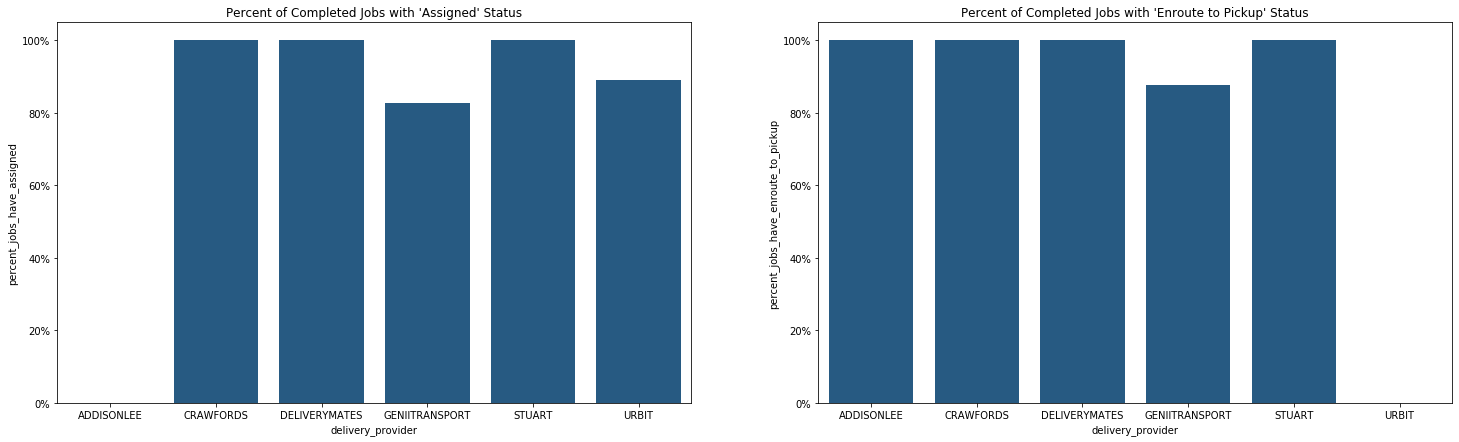

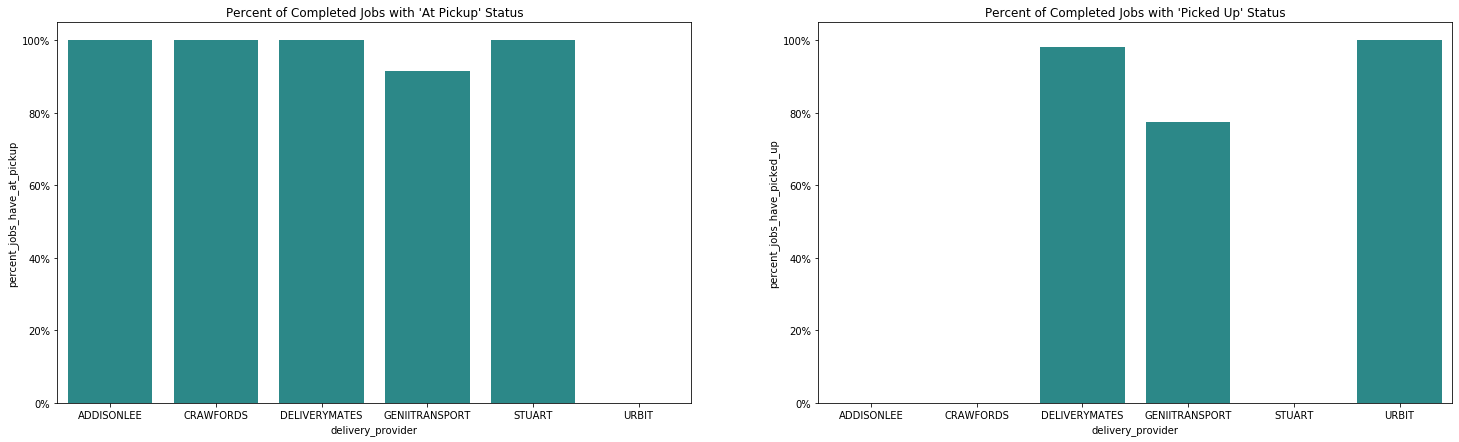

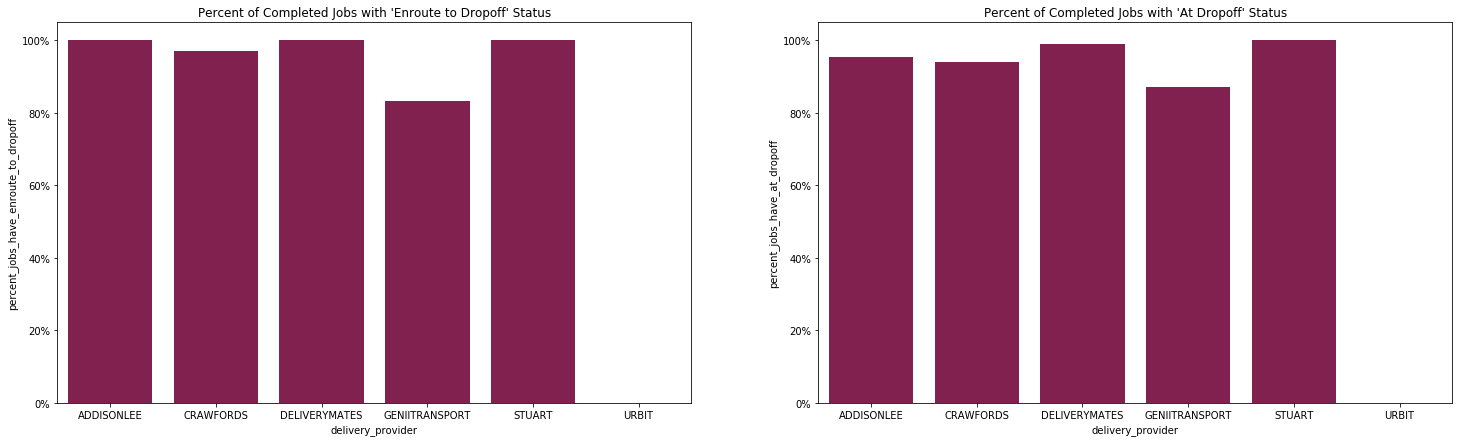

In [34]:
f, axes = plt.subplots(1, 2, figsize=(25, 7), sharex=True)

ax1=sns.barplot(x = status_df5['delivery_provider'],y=status_df5['percent_jobs_have_assigned'] ,ax=axes[0], color='#185c91')
ax2=sns.barplot(x = status_df5['delivery_provider'],y=status_df5['percent_jobs_have_enroute_to_pickup'] ,ax=axes[1], color = '#185c91')
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax1.set_title("Percent of Completed Jobs with 'Assigned' Status")
ax2.set_title("Percent of Completed Jobs with 'Enroute to Pickup' Status")

f, axes = plt.subplots(1, 2, figsize=(25, 7), sharex=True)

ax1=sns.barplot(x = status_df5['delivery_provider'],y=status_df5['percent_jobs_have_at_pickup'] ,ax=axes[0], color='#1c9898')
ax2=sns.barplot(x = status_df5['delivery_provider'],y=status_df5['percent_jobs_have_picked_up'] ,ax=axes[1], color='#1c9898')
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax1.set_title("Percent of Completed Jobs with 'At Pickup' Status")
ax2.set_title("Percent of Completed Jobs with 'Picked Up' Status")

f, axes = plt.subplots(1, 2, figsize=(25, 7), sharex=True)

ax1=sns.barplot(x = status_df5['delivery_provider'],y=status_df5['percent_jobs_have_enroute_to_dropoff'] ,ax=axes[0], color='#90114e')
ax2=sns.barplot(x = status_df5['delivery_provider'],y=status_df5['percent_jobs_have_at_dropoff'] ,ax=axes[1], color='#90114e')
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax1.set_title("Percent of Completed Jobs with 'Enroute to Dropoff' Status")
ax2.set_title("Percent of Completed Jobs with 'At Dropoff' Status")



### These Graphs show the Average and Median Time's between Each Status Change, Broken down by DP

Text(0.5, 1.0, "Median Time Between 'Assigned' and 'Enroute to Pickup' Statuses (Seconds)")

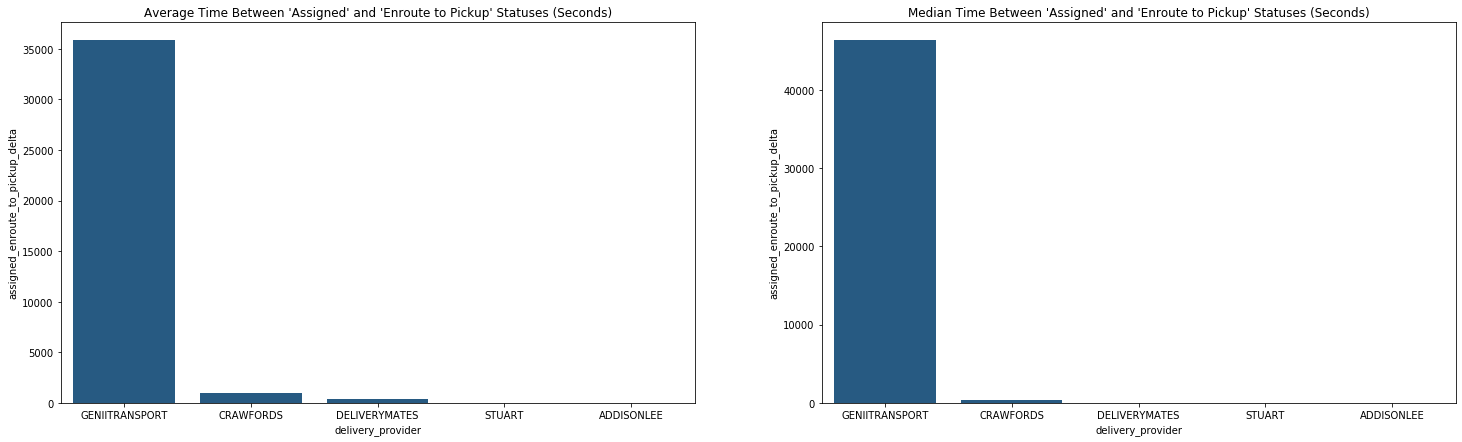

In [35]:
df6 = df6.sort_values('assigned_enroute_to_pickup_delta', ascending=False)

f, axes = plt.subplots(1, 2, figsize=(25, 7), sharex=True)
ax1 = sns.barplot(x=df6['delivery_provider'], y=df6['assigned_enroute_to_pickup_delta'],ax=axes[0], color='#185c91')
df7 = df7.sort_values('assigned_enroute_to_pickup_delta', ascending=False)
ax2 = sns.barplot(x=df7['delivery_provider'], y=df7['assigned_enroute_to_pickup_delta'],ax=axes[1], color='#185c91')
ax1.set_title("Average Time Between 'Assigned' and 'Enroute to Pickup' Statuses (Seconds)")
ax2.set_title("Median Time Between 'Assigned' and 'Enroute to Pickup' Statuses (Seconds)")

Text(0.5, 1.0, "Median Time Between Enroute to Pickup' and 'At Pickup' Statuses (Seconds)")

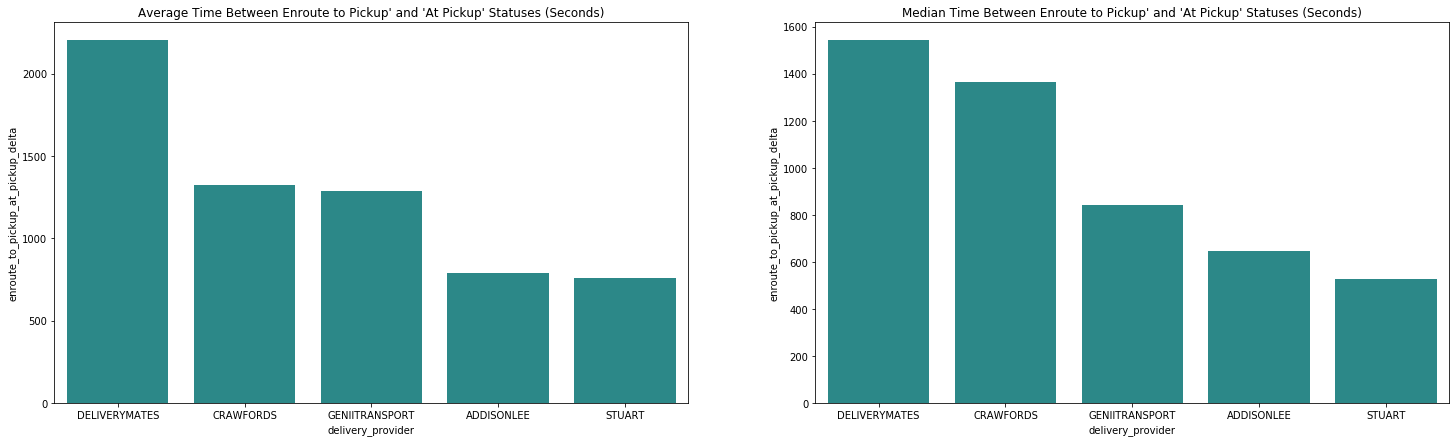

In [36]:
df6 = df6.sort_values('enroute_to_pickup_at_pickup_delta', ascending=False)

f, axes = plt.subplots(1, 2, figsize=(25, 7), sharex=True)
ax1 = sns.barplot(x=df6['delivery_provider'], y=df6['enroute_to_pickup_at_pickup_delta'],ax=axes[0], color='#1c9898')
df7 = df7.sort_values('enroute_to_pickup_at_pickup_delta', ascending=False)
ax2 = sns.barplot(x=df7['delivery_provider'], y=df7['enroute_to_pickup_at_pickup_delta'],ax=axes[1], color='#1c9898')
ax1.set_title("Average Time Between Enroute to Pickup' and 'At Pickup' Statuses (Seconds)")
ax2.set_title("Median Time Between Enroute to Pickup' and 'At Pickup' Statuses (Seconds)")

Text(0.5, 1.0, "Median Time Between At Pickup' and 'Picked Up' Statuses (Seconds)")

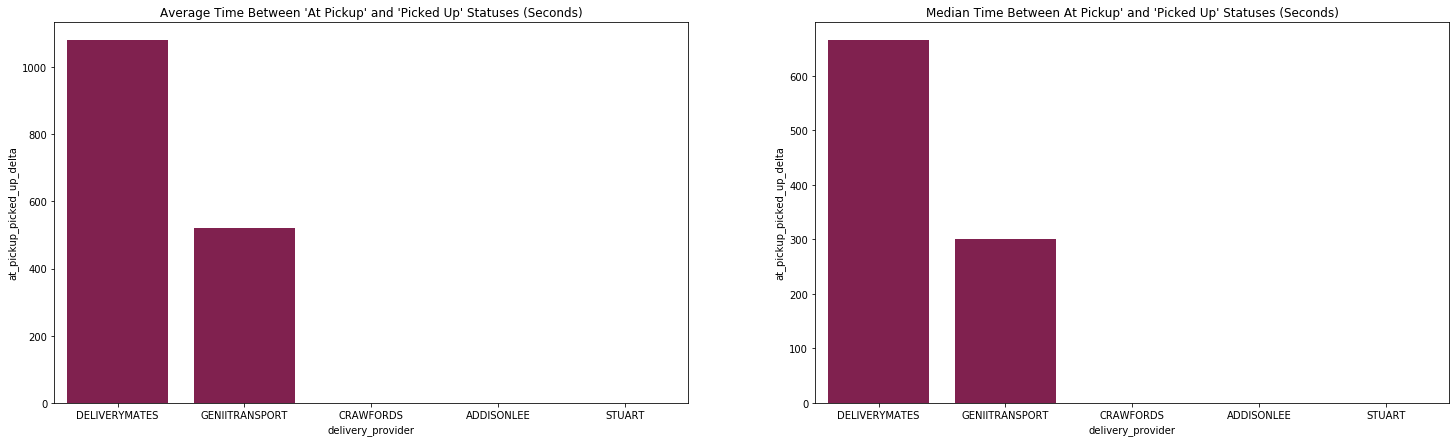

In [37]:
df6 = df6.sort_values('at_pickup_picked_up_delta', ascending=False)

f, axes = plt.subplots(1, 2, figsize=(25, 7), sharex=True)
ax1 = sns.barplot(x=df6['delivery_provider'], y=df6['at_pickup_picked_up_delta'],ax=axes[0], color='#90114e')
df7 = df7.sort_values('at_pickup_picked_up_delta', ascending=False)
ax2 = sns.barplot(x=df7['delivery_provider'], y=df7['at_pickup_picked_up_delta'],ax=axes[1], color='#90114e')
ax1.set_title("Average Time Between 'At Pickup' and 'Picked Up' Statuses (Seconds)")
ax2.set_title("Median Time Between At Pickup' and 'Picked Up' Statuses (Seconds)")



Text(0.5, 1.0, "Median Time Between At Pickup' and 'Enroute to Dropoff' Statuses (Seconds)")

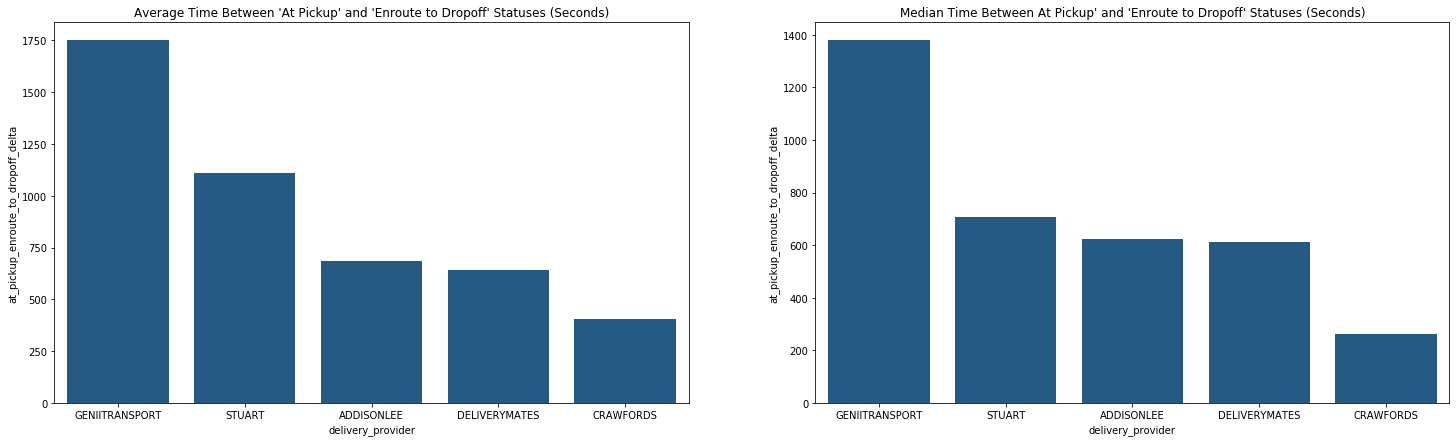

In [38]:
df6 = df6.sort_values('at_pickup_enroute_to_dropoff_delta', ascending=False)

f, axes = plt.subplots(1, 2, figsize=(25, 7), sharex=True)
ax1 = sns.barplot(x=df6['delivery_provider'], y=df6['at_pickup_enroute_to_dropoff_delta'],ax=axes[0], color='#185c91')
df7 = df7.sort_values('at_pickup_enroute_to_dropoff_delta', ascending=False)
ax2 = sns.barplot(x=df7['delivery_provider'], y=df7['at_pickup_enroute_to_dropoff_delta'],ax=axes[1], color='#185c91')
ax1.set_title("Average Time Between 'At Pickup' and 'Enroute to Dropoff' Statuses (Seconds)")
ax2.set_title("Median Time Between At Pickup' and 'Enroute to Dropoff' Statuses (Seconds)")



Text(0.5, 1.0, "Median Time Between 'Picked Up' and 'Enroute to Dropoff' Statuses (Seconds)")

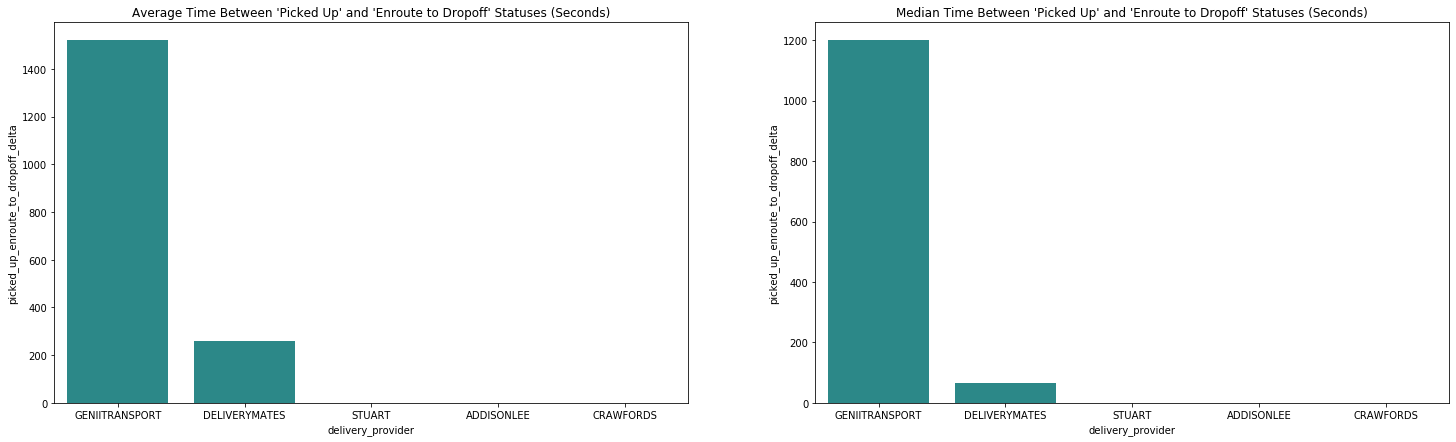

In [39]:
df6 = df6.sort_values('picked_up_enroute_to_dropoff_delta', ascending=False)

f, axes = plt.subplots(1, 2, figsize=(25, 7), sharex=True)
ax1 = sns.barplot(x=df6['delivery_provider'], y=df6['picked_up_enroute_to_dropoff_delta'],ax=axes[0], color='#1c9898')
df7 = df7.sort_values('picked_up_enroute_to_dropoff_delta', ascending=False)
ax2 = sns.barplot(x=df7['delivery_provider'], y=df7['picked_up_enroute_to_dropoff_delta'],ax=axes[1], color='#1c9898')
ax1.set_title("Average Time Between 'Picked Up' and 'Enroute to Dropoff' Statuses (Seconds)")
ax2.set_title("Median Time Between 'Picked Up' and 'Enroute to Dropoff' Statuses (Seconds)")




Text(0.5, 1.0, "Median Time Between Enroute to Dropoff' and 'At Dropoff' Statuses (Seconds)")

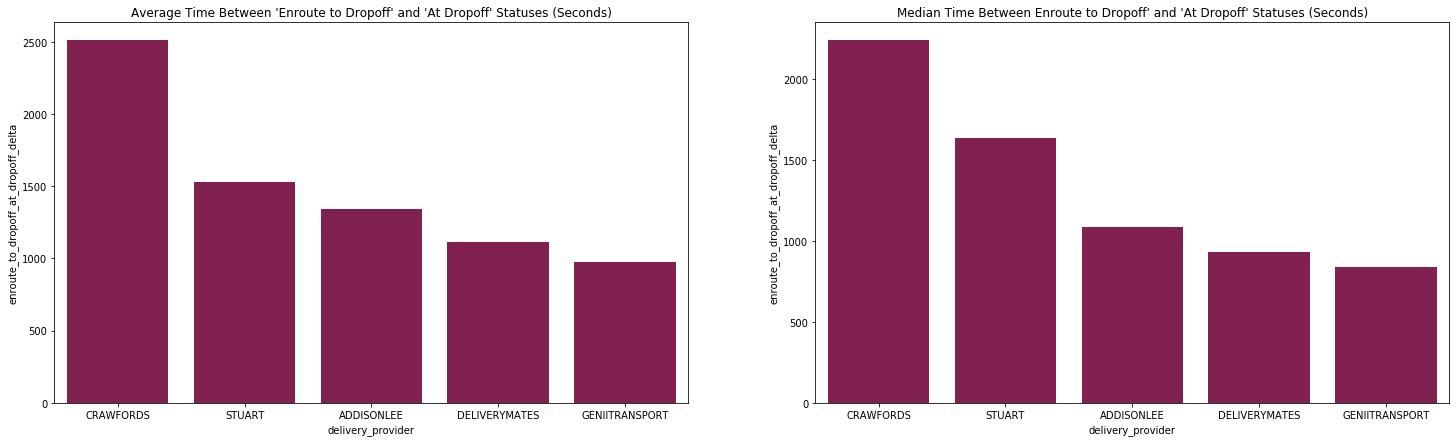

In [40]:
df6 = df6.sort_values('enroute_to_dropoff_at_dropoff_delta', ascending=False)

f, axes = plt.subplots(1, 2, figsize=(25, 7), sharex=True)
ax1 = sns.barplot(x=df6['delivery_provider'], y=df6['enroute_to_dropoff_at_dropoff_delta'],ax=axes[0], color='#90114e')
df7 = df7.sort_values('enroute_to_dropoff_at_dropoff_delta', ascending=False)
ax2 = sns.barplot(x=df7['delivery_provider'], y=df7['enroute_to_dropoff_at_dropoff_delta'],ax=axes[1], color='#90114e')
ax1.set_title("Average Time Between 'Enroute to Dropoff' and 'At Dropoff' Statuses (Seconds)")
ax2.set_title("Median Time Between Enroute to Dropoff' and 'At Dropoff' Statuses (Seconds)")




Text(0.5, 1.0, "Median Time Between 'At Dropoff' and 'Complete' Statuses (Seconds)")

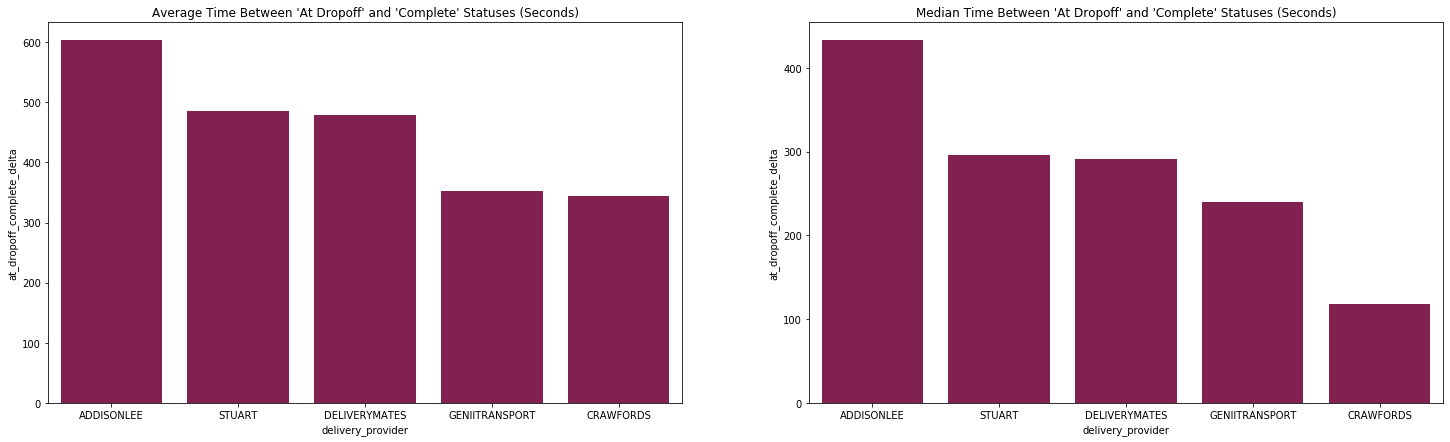

In [41]:
df6 = df6.sort_values('at_dropoff_complete_delta', ascending=False)

f, axes = plt.subplots(1, 2, figsize=(25, 7), sharex=True)
ax1 = sns.barplot(x=df6['delivery_provider'], y=df6['at_dropoff_complete_delta'],ax=axes[0], color='#90114e')
df7 = df7.sort_values('at_dropoff_complete_delta', ascending=False)
ax2 = sns.barplot(x=df7['delivery_provider'], y=df7['at_dropoff_complete_delta'],ax=axes[1], color='#90114e')
ax1.set_title("Average Time Between 'At Dropoff' and 'Complete' Statuses (Seconds)")
ax2.set_title("Median Time Between 'At Dropoff' and 'Complete' Statuses (Seconds)")


# Distribution of Times Between Status Changes

### Assigned to Enroute to Pickup Distribution

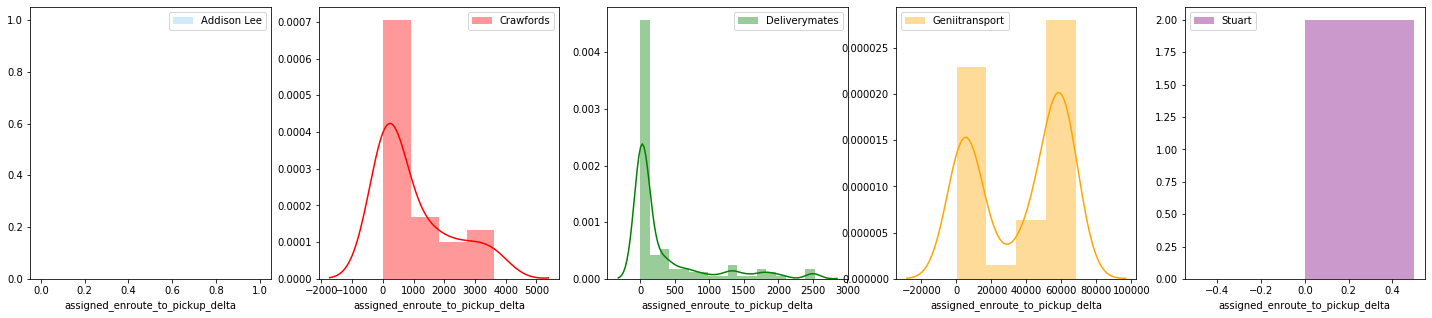

In [42]:
f, axes = plt.subplots(1, 5, figsize=(25, 5), sharex=False)
al = df5[df5['delivery_provider']=='ADDISONLEE']
crawfords = df5[df5['delivery_provider']=='CRAWFORDS']
otl = df5[df5['delivery_provider']=='DELIVERYMATES']
genii = df5[df5['delivery_provider']=='GENIITRANSPORT']
stuart = df5[df5['delivery_provider']=='STUART']
ax1=sns.distplot(al['assigned_enroute_to_pickup_delta'] , color="skyblue", label="Addison Lee", ax=axes[0])
ax2=sns.distplot(crawfords['assigned_enroute_to_pickup_delta'] , color="red", label="Crawfords", ax=axes[1])
ax3=sns.distplot(otl['assigned_enroute_to_pickup_delta'] , color="green", label="Deliverymates", ax=axes[2])
ax4=sns.distplot(genii['assigned_enroute_to_pickup_delta'] , color="orange", label="Geniitransport", ax=axes[3])
ax5=sns.distplot(stuart['assigned_enroute_to_pickup_delta'] , color="purple", label="Stuart", ax=axes[4])
ax1 = ax1.legend()
ax2 = ax2.legend()
ax3 = ax3.legend()
ax4 = ax4.legend()
ax5 = ax5.legend()

### Enroute to Pickup to At Pickup Distribution (Seconds)

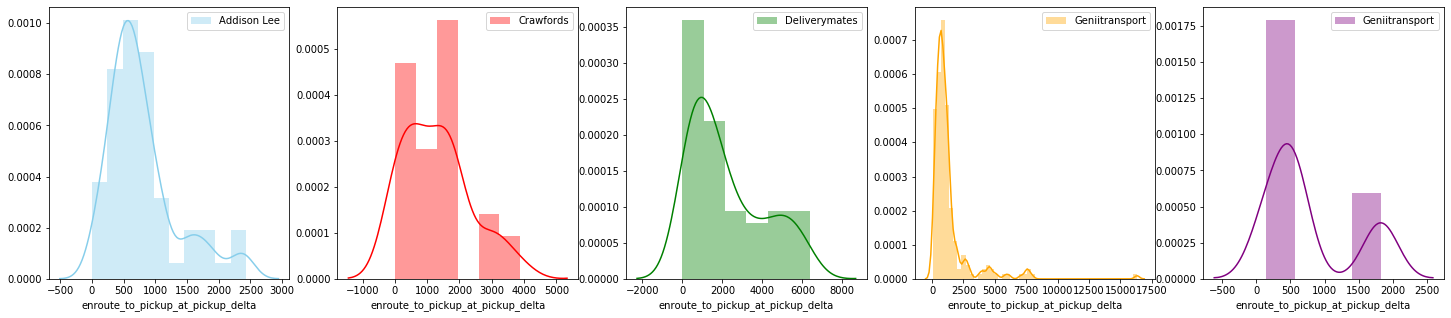

In [43]:
f, axes = plt.subplots(1, 5, figsize=(25, 5), sharex=False)
ax1=sns.distplot(al['enroute_to_pickup_at_pickup_delta'] , color="skyblue", label="Addison Lee", ax=axes[0])
ax2=sns.distplot(crawfords['enroute_to_pickup_at_pickup_delta'] , color="red", label="Crawfords", ax=axes[1])
ax3=sns.distplot(otl['enroute_to_pickup_at_pickup_delta'] , color="green", label="Deliverymates", ax=axes[2])
ax4=sns.distplot(genii['enroute_to_pickup_at_pickup_delta'] , color="orange", label="Geniitransport", ax=axes[3])
ax5=sns.distplot(stuart['enroute_to_pickup_at_pickup_delta'] , color="purple", label="Geniitransport", ax=axes[4])
ax1 = ax1.legend()
ax2 = ax2.legend()
ax3 = ax3.legend()
ax4 = ax4.legend()
ax5 = ax5.legend()

### At Pickup to Picked Up Distribution (Seoconds)

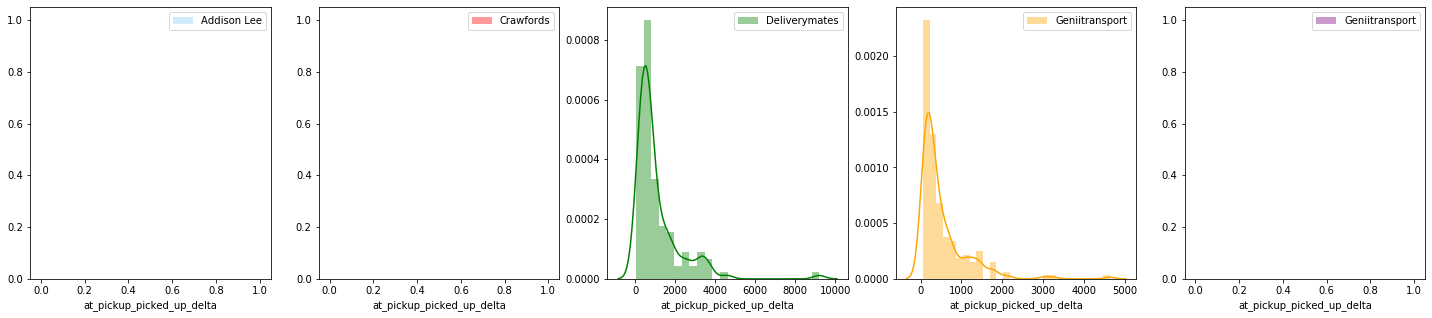

In [44]:
f, axes = plt.subplots(1, 5, figsize=(25, 5), sharex=False)
ax1=sns.distplot(al['at_pickup_picked_up_delta'] , color="skyblue", label="Addison Lee", ax=axes[0])
ax2=sns.distplot(crawfords['at_pickup_picked_up_delta'] , color="red", label="Crawfords", ax=axes[1])
ax3=sns.distplot(otl['at_pickup_picked_up_delta'] , color="green", label="Deliverymates", ax=axes[2])
ax4=sns.distplot(genii['at_pickup_picked_up_delta'] , color="orange", label="Geniitransport", ax=axes[3])
ax5=sns.distplot(stuart['at_pickup_picked_up_delta'] , color="purple", label="Geniitransport", ax=axes[4])
ax1 = ax1.legend()
ax2 = ax2.legend()
ax3 = ax3.legend()
ax4 = ax4.legend()
ax5 = ax5.legend()

### At Pickup to Enroute to Dropoff Distribution Seconds

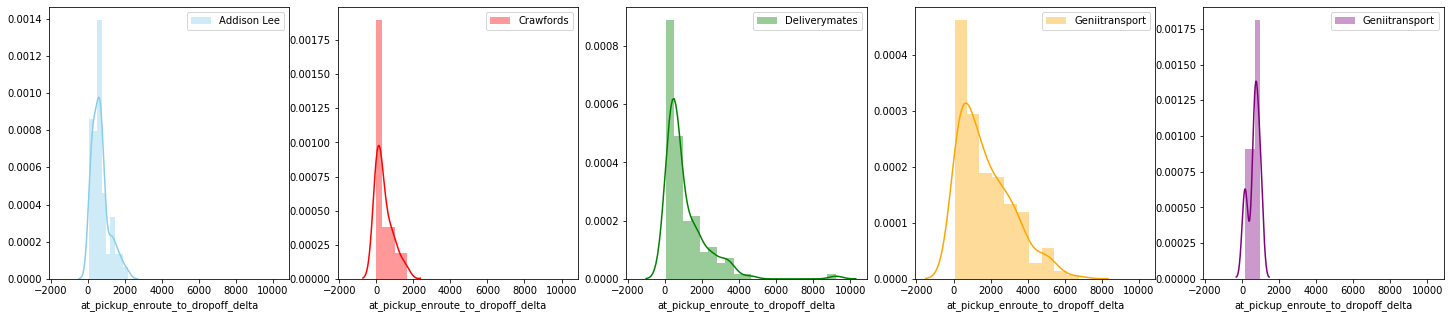

In [45]:
f, axes = plt.subplots(1, 5, figsize=(25, 5), sharex=True)
ax1=sns.distplot(al['at_pickup_enroute_to_dropoff_delta'] , color="skyblue", label="Addison Lee", ax=axes[0])
ax2=sns.distplot(crawfords['at_pickup_enroute_to_dropoff_delta'] , color="red", label="Crawfords", ax=axes[1])
ax3=sns.distplot(otl['at_pickup_enroute_to_dropoff_delta'] , color="green", label="Deliverymates", ax=axes[2])
ax4=sns.distplot(genii['at_pickup_enroute_to_dropoff_delta'] , color="orange", label="Geniitransport", ax=axes[3])
ax5=sns.distplot(stuart['at_pickup_enroute_to_dropoff_delta'] , color="purple", label="Geniitransport", ax=axes[4])
ax1 = ax1.legend()
ax2 = ax2.legend()
ax3 = ax3.legend()
ax4 = ax4.legend()
ax5 = ax5.legend()

### Picked up to Enroute to Dropoff Distribution (Seconds)

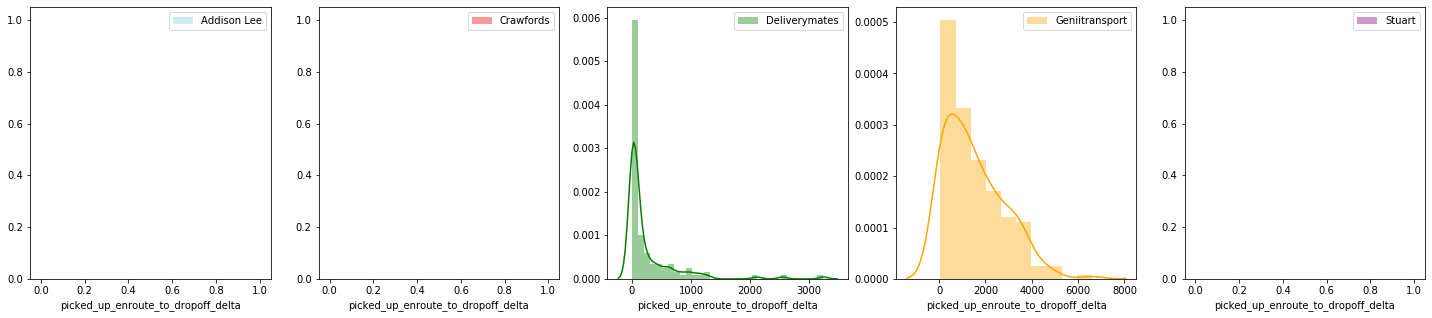

In [46]:
f, axes = plt.subplots(1, 5, figsize=(25, 5), sharex=False)
ax1=sns.distplot(al['picked_up_enroute_to_dropoff_delta'] , color="skyblue", label="Addison Lee", ax=axes[0])
ax2=sns.distplot(crawfords['picked_up_enroute_to_dropoff_delta'] , color="red", label="Crawfords", ax=axes[1])
ax3=sns.distplot(otl['picked_up_enroute_to_dropoff_delta'] , color="green", label="Deliverymates", ax=axes[2])
ax4=sns.distplot(genii['picked_up_enroute_to_dropoff_delta'] , color="orange", label="Geniitransport", ax=axes[3])
ax5=sns.distplot(stuart['picked_up_enroute_to_dropoff_delta'] , color="purple", label="Stuart", ax=axes[4])
ax1 = ax1.legend()
ax2 = ax2.legend()
ax3 = ax3.legend()
ax4 = ax4.legend()
ax5 = ax5.legend()

### Enroute to Dropoff to At Dropoff Distribution (Seconds)

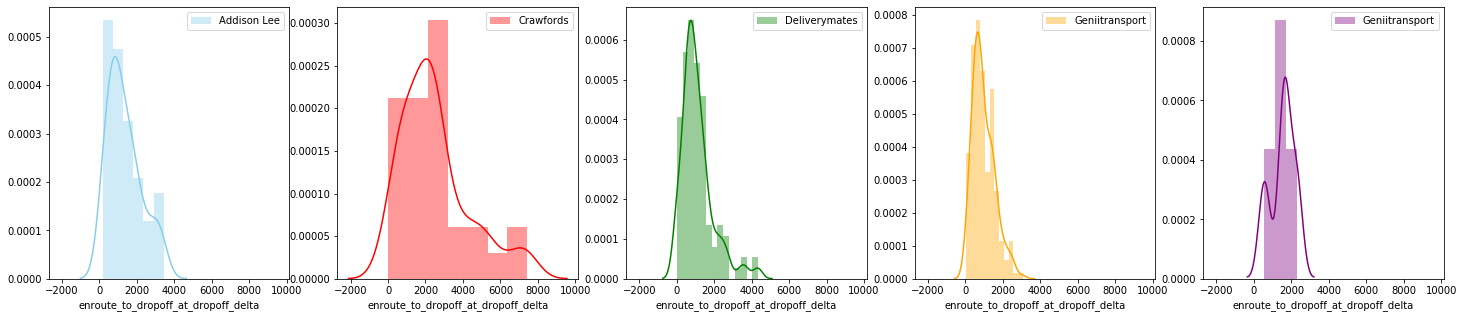

In [47]:
f, axes = plt.subplots(1, 5, figsize=(25, 5), sharex=True)
ax1=sns.distplot(al['enroute_to_dropoff_at_dropoff_delta'] , color="skyblue", label="Addison Lee", ax=axes[0])
ax2=sns.distplot(crawfords['enroute_to_dropoff_at_dropoff_delta'] , color="red", label="Crawfords", ax=axes[1])
ax3=sns.distplot(otl['enroute_to_dropoff_at_dropoff_delta'] , color="green", label="Deliverymates", ax=axes[2])
ax4=sns.distplot(genii['enroute_to_dropoff_at_dropoff_delta'] , color="orange", label="Geniitransport", ax=axes[3])
ax5=sns.distplot(stuart['enroute_to_dropoff_at_dropoff_delta'] , color="purple", label="Geniitransport", ax=axes[4])
ax1 = ax1.legend()
ax2 = ax2.legend()
ax3 = ax3.legend()
ax4 = ax4.legend()
ax5 = ax5.legend()

### At Dropoff to Complete Distribution Seconds

# 